In [41]:
import numpy as np
import matplotlib.pyplot as plt
import foscat.scat_cov as sc
import foscat.Synthesis as synthe
f=sc.funct()

In [42]:
path='/home/jmdeloui/CO2TEST/'


In [230]:
#***check if data is uploaded depending on choices
atm = 1

x=[]

CO2_coeff_tab = [0.8,0.9,1.00, 1.10, 1.20]
for k in range(5):
    CO2_coeff = CO2_coeff_tab[k]
    for b in range(3):
        band=b+1
        
        #Choose line to read
        
        Ps_ind = 6 #(/ 893, 923, 953, 983, 1013, 1043 /) in hPa
        sza_ind = 15 #(/ 0.014, 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70. /)
        H2O_ind = 9 #(/ 0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40 /) 
        alb_ind = 4 #(/ 0.05, 0.25, 0.45, 0.65 /)
        ########################################################################################
        
        file_learning = path+f'basis_{CO2_coeff:.2f}CO2_microcarb_B{band}_atm000{atm}.ddb'
        
        if band==1:
            n = 365
        elif band==2:
            n = 335
        elif band==3:
            n = 348
        
        target_line = 540*(Ps_ind - 1) + 36*(sza_ind - 1) + 4*(H2O_ind - 1) + alb_ind + 1 #+1 because the first line are wavenumbers
        #3241 lines? So 3240 without the wavenumbers
        
        with open(file_learning, 'rb') as file:
            #for i in range(target_line-1):
        #        junk = np.fromfile(file,dtype='float32', count=1000)
        #        print(junk)
        #    line_read = np.fromfile(file,dtype='float32',count=1000)
        
        
            line_read = np.fromfile(file,dtype='float32',count=-1)
            index = np.where(line_read !=0)
            index = index[0]
        
        #line_read contains the whole document, we remove all the null values
        line_learning = []
        for i in range(len(line_read)):
            if line_read[i] != 0:
                line_learning.append(line_read[i])
        
        
        #we store the first line containing the wavenumbers
        wavenumber = line_learning[0:n]
        
        #we separate the long list into lines (4 parameters, then spectra of length n, 3240 times)
        line_size = n+4 #for the 4 parameters at the start of each line before the spectra
        rad_learning = np.zeros((3240,line_size))
        
        for i in range(3240):
            ind = i*line_size + len(wavenumber)
            rad_learning[i,:] = line_learning[ind:ind+line_size]
        if b==0:
            rad_learning_band=rad_learning[:,4:]
        else:
            rad_learning_band=np.concatenate([rad_learning_band,rad_learning[:,4:]],1)
            
    x.append(rad_learning_band)

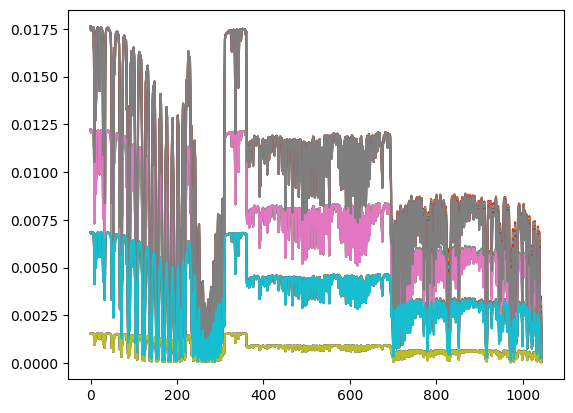

In [231]:
for k in range(30):
    plt.plot(x[0][k,4:])

In [232]:
data=np.vstack(x)
data=data[:,4:]
co2=(5*np.arange(data.shape[0])/data.shape[0]).astype('int')
idx=np.argsort(np.random.rand(data.shape[0]))
amp=np.median(data,1)
data/=amp[:,None]
data=data[idx]
co2=co2[idx]

data_train=data[0:data.shape[0]*2//3]
co2_train=co2[0:data.shape[0]*2//3]
data_valid=data[data.shape[0]*2//3:]
co2_valid=co2[data.shape[0]*2//3:]

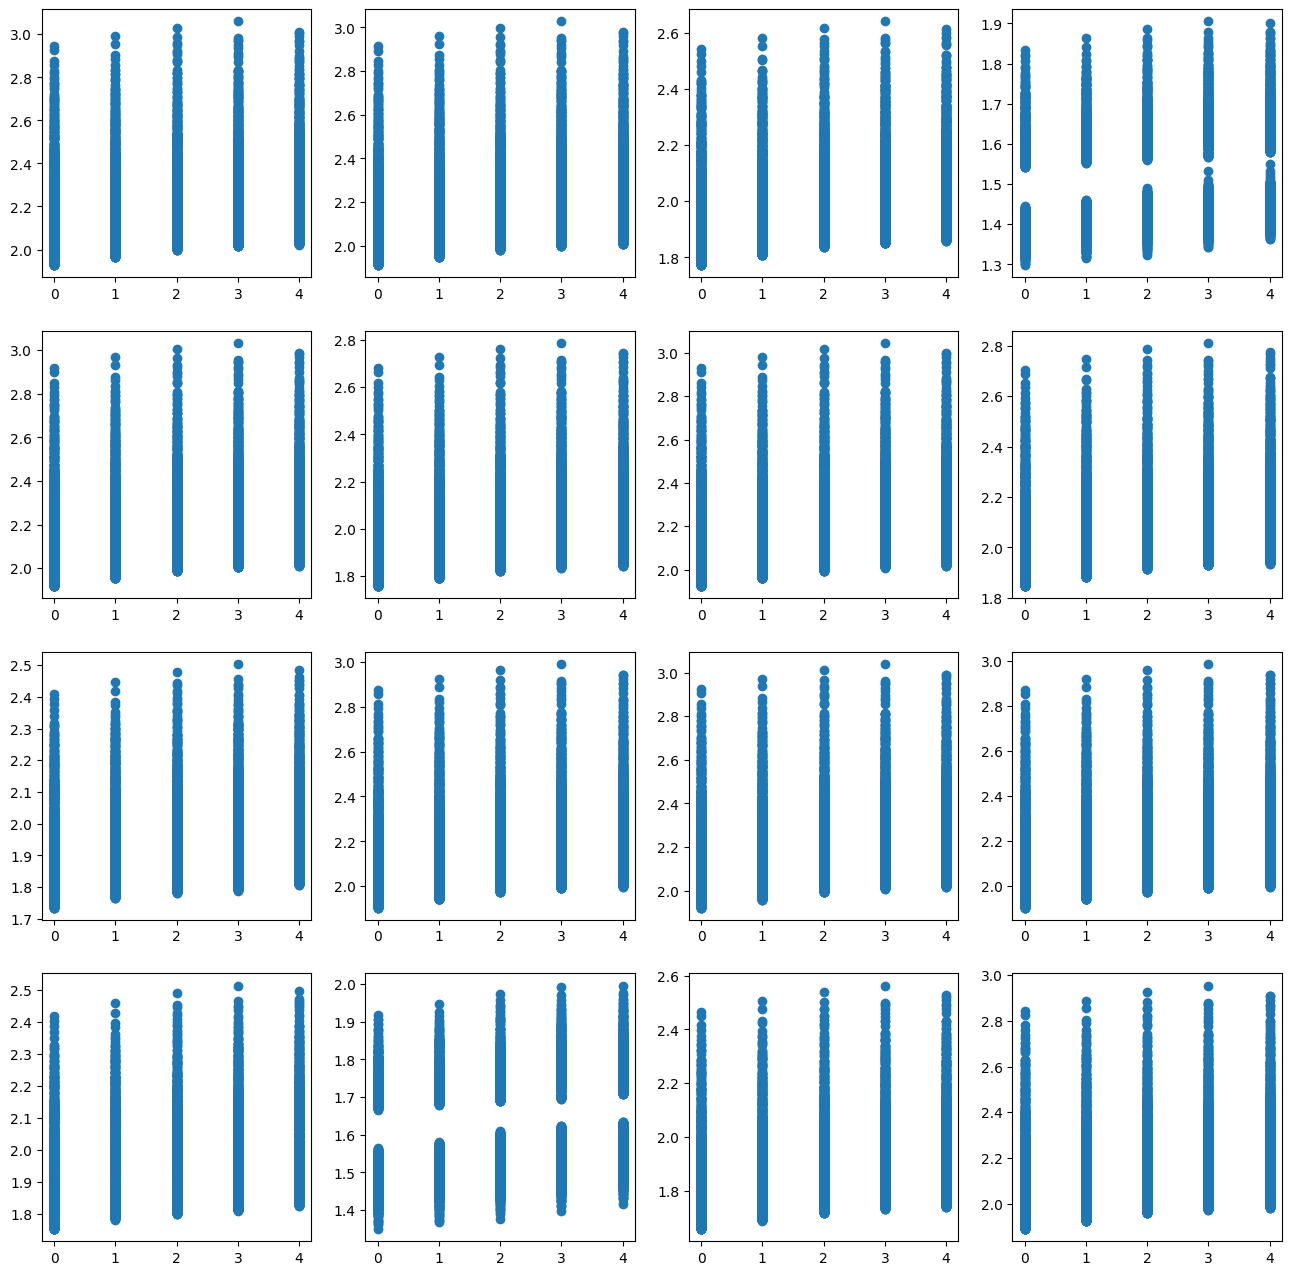

In [233]:
plt.figure(figsize=(16,16))
for k in range(16):
    plt.subplot(4,4,1+k)
    plt.scatter(co2_train,data_train[:,k*4])

In [234]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(data_train)

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


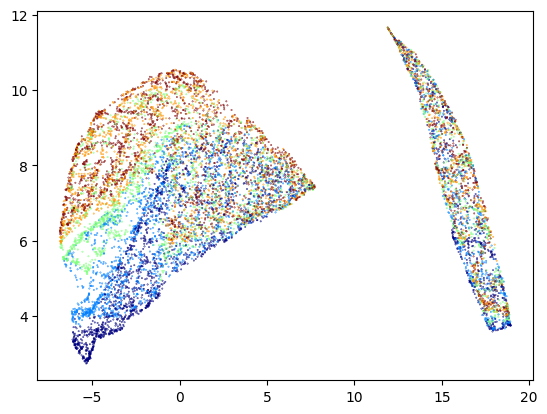

In [237]:
plt.scatter(X_umap[:,0],X_umap[:,1],c=co2_train,cmap='jet',s=0.1)

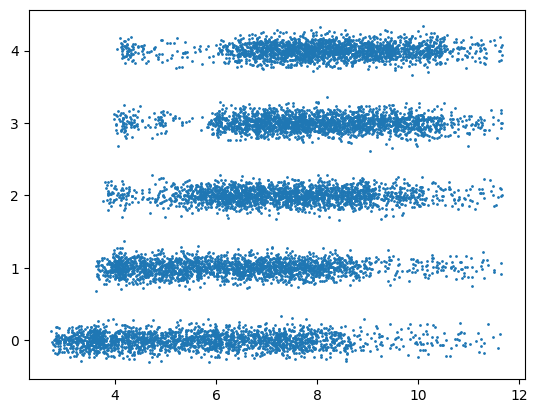

In [236]:
plt.scatter(X_umap[:,1],co2_train+np.random.randn(co2_train.shape[0])/10,s=1)

In [238]:
N_val=data_train.shape[1]
N_class=5
N_level=1

import torch

def select_from_tensor(A, I):
    """
    A: torch.Tensor of shape (N, M)
    I: torch.LongTensor of shape (N,) with indices per row
    Returns: torch.Tensor of shape (N,) where result[i] = A[i, I[i]]
    """
    N = A.shape[0]
    batch_indices = torch.arange(N, device=A.device)
    result = A[batch_indices, I]
    return result
    
def compute_nn():

    nn=N_val*N_class+N_class
    for k in range(1,N_level):
        nn+=N_class*N_class+N_class
    return nn
    
def compute(x,scat_operator,x_train):

    nn=0
    w=scat_operator.backend.bk_reshape(x[0:N_val*N_class],[N_val,N_class])
    b=scat_operator.backend.bk_reshape(x[N_val*N_class:N_val*N_class+N_class],[1,N_class])
    logits=scat_operator.backend.bk_matmul(x_train, w) + b
    nn+=N_val*N_class+N_class
    for k in range(1,N_level):
        logits = scat_operator.backend.bk_relu(logits)
        w=scat_operator.backend.bk_reshape(x[nn:nn+N_class*N_class],[N_class,N_class])
        b=scat_operator.backend.bk_reshape(x[nn+N_class*N_class:nn+N_class*N_class+N_class],[1,N_class])
        logits=scat_operator.backend.bk_matmul(logits, w) + b
        nn+=N_class*N_class+N_class
    
    return scat_operator.backend.backend.nn.functional.softmax(logits, dim=-1) 
    
def The_loss(x,scat_operator,args,return_all=False):

    x_train  = args[0]
    itrain   = args[1]
    
    learn=compute(x,scat_operator,x_train)
    loss = -scat_operator.backend.bk_log(select_from_tensor(learn,itrain))
    return scat_operator.backend.bk_reduce_mean(loss)

In [251]:
w=(np.random.rand(compute_nn())-0.5)/np.sqrt(N_class)*0.1

loss=synthe.Loss(The_loss,f,
                f.backend.bk_cast(data_train),
                co2_train)

sy = synthe.Synthesis([loss])

w=sy.run(f.backend.bk_cast(w),EVAL_FREQUENCY=100,NUM_EPOCHS = 1000)

Total number of loss  1
Itt      0 L=      1.94 (      1.94 ) 0.017s 
Itt    100 L=     0.452 (     0.452 ) 0.477s 
Itt    200 L=    0.0135 (    0.0135 ) 0.288s 
Itt    300 L=   0.00504 (   0.00504 ) 0.307s 
Itt    400 L=   0.00204 (   0.00204 ) 0.282s 
Itt    500 L=  0.000759 (  0.000759 ) 0.293s 
Itt    600 L=  3.55e-07 (  3.55e-07 ) 0.297s 
Final Loss  2.2075798133958102e-10


[0. 0. 1. 0. 0.]


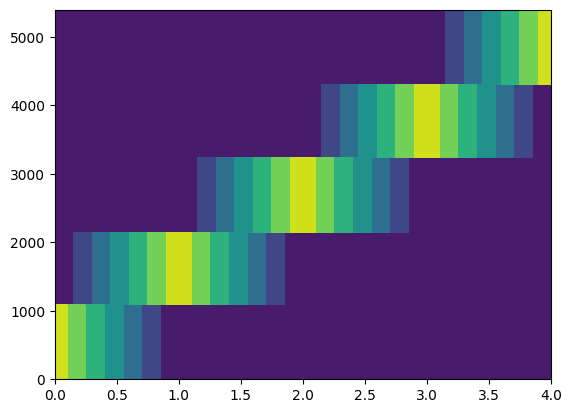

In [252]:
res=compute(f.backend.bk_cast(w),f,f.backend.bk_cast(data_valid)).cpu().numpy()

idx=np.argsort(co2_valid)
plt.contourf(res[idx])
print(res[0])

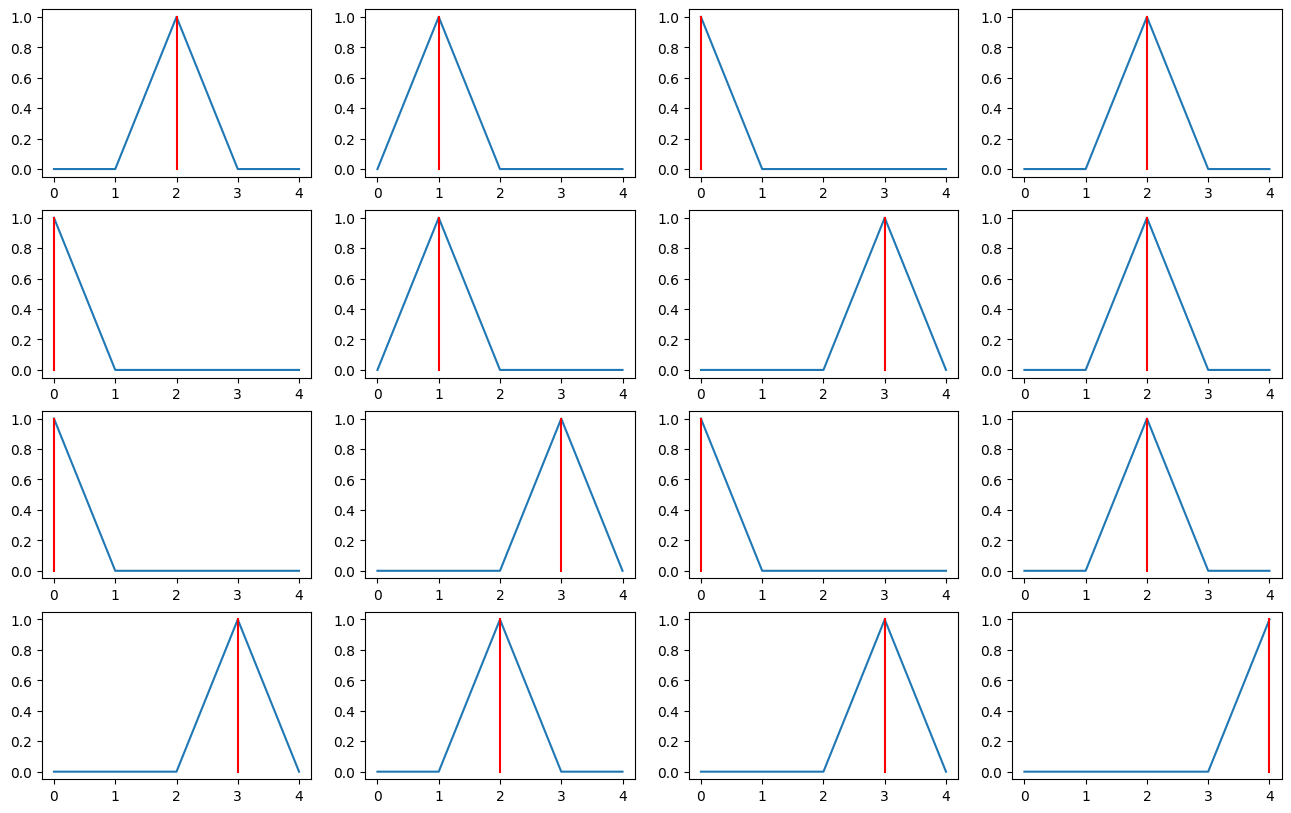

In [253]:
plt.figure(figsize=(16,10))
for k in range(16):
    plt.subplot(4,4,1+k)
    plt.plot(res[k])
    plt.plot([co2_valid[k],co2_valid[k]],[0,1],color='r')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.399e+03]),
 array([0.9962346 , 0.99636012, 0.99648565, 0.99661112, 0.99673665,
        0.99686217, 0.9969877 , 0.99711317, 0.9972387 , 0.99736422,
        0.99748975, 0.99761522, 0.99774075, 0.99786627, 0.9979918 ,
        0.99811733, 0.9982428 , 0.99836832, 0.99849385, 0.99861938,
        0.99874485, 0.99887037, 0.9989959 , 0.99912143, 0.9992469 ,
        0.99937242, 0.99949795, 0.99962348, 0.99974895, 0.99987447,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x7fd39a4f8c10>])

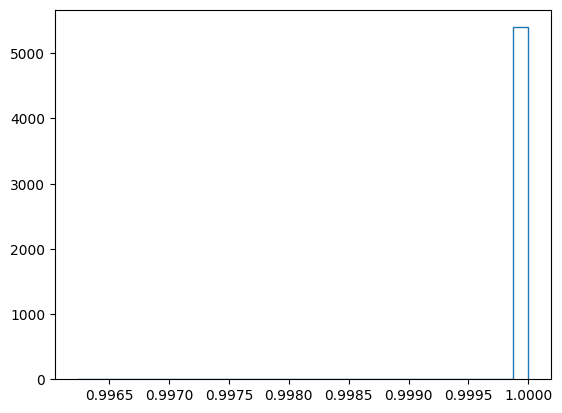

In [254]:
resc=np.cumsum(res,1)
plt.hist(resc[np.arange(co2_valid.shape[0]),co2_valid],histtype='step',bins=30)